In [1]:
from siepic import all as pdk
from ipkiss3 import all as i3
from ipkiss3 import constants
from ipkiss.process.layer_map import GenericGdsiiPPLayerOutputMap
from mzi_pcell_ybranch_3port import MZI_YB_3port
from mzi_pcell_bdc import MZI_BDC
from mzi_pcell_ybranch_3port_calib import MZI_YB_3port_calib
from mzi_pcell_bdc_calib import MZI_BDC_calib
from datetime import datetime
import numpy as np
import pylab as plt
import pickle
from scipy.io import savemat, loadmat

In [2]:
# We make a copy of the layer dictionary to freely modify it
pplayer_map = dict(i3.TECH.GDSII.LAYERTABLE)
# Write the content to be written on WG_P6NM on Silicon layer directly
pplayer_map[i3.TECH.PROCESS.WG_P6NM, i3.TECH.PURPOSE.DRAWING] = pplayer_map[i3.TECH.PROCESS.WG, i3.TECH.PURPOSE.DRAWING]
output_layer_map = GenericGdsiiPPLayerOutputMap(pplayer_map=pplayer_map)

In [3]:
# The optimization functions to determine the lengths of the long arm of the interferometers
def define_control_point_mzi_bdc(delay_length, bend_radius, control_point_y):
    """Defines a control point based on the desired delay_length for MZI with BDC"""

    def f(x):
        device = MZI_BDC(
            control_point=(x[0], control_point_y),
            bend_radius=bend_radius,
        )
        right_arm_length = device.get_connector_instances()[1].reference.trace_length()
        left_arm_length = device.get_connector_instances()[0].reference.trace_length()
        current_delay_length = right_arm_length - left_arm_length
        cost = current_delay_length - delay_length
        return np.abs(cost)

    from scipy.optimize import minimize

    control_point_x = minimize(f, x0=np.array(70.0), tol=1e-2, bounds=((45.0, 200.0),)).x[0]
    return control_point_x, control_point_y


def define_control_point_mzi_yb(delay_length_tuple, bend_radius, cp_y_tup):
    """Defines a control point based on the desired delay_length for MZI with Y-branch"""

    def f(x):
        device = MZI_YB_3port(
            control_point1=(x[0], cp_y_tup[0]),
            control_point2=(x[1], cp_y_tup[1]),
            bend_radius=bend_radius,
        )
        mzi1_long_arm_length = device.get_connector_instances()[0].reference.trace_length()
        mzi1_short_arm_length = device.get_connector_instances()[1].reference.trace_length()
        mzi2_long_arm_length = device.get_connector_instances()[2].reference.trace_length()
        mzi2_short_arm_length = device.get_connector_instances()[3].reference.trace_length()
        mzi1_delay_length = mzi1_long_arm_length - mzi1_short_arm_length
        mzi2_delay_length = mzi2_long_arm_length - mzi2_short_arm_length
        cost1 = mzi1_delay_length - delay_length_tuple[0]
        cost2 = mzi2_delay_length - delay_length_tuple[1]
        cost = cost1**2 + cost2**2
        return np.abs(cost)

    from scipy.optimize import minimize

    cp_x_tup = minimize(f, x0=np.array([70.0, 70.0]), tol=1e-2).x
    return [(x , cp_y_tup[i]) for i, x in enumerate(cp_x_tup)]


In [4]:
# Parameters for the MZI Y-branch sweep
delay_lengths_tuples = [(50.0, 100.0), (150.0, 200.0)]
bend_radius = 5.0
x0 = 40.0
y0 = 20.0
spacing_x = 80.0

insts = dict()
specs = []

In [5]:
# Create the floor plan for EdX design area
floorplan = pdk.FloorPlan(name="FLOORPLAN", size=(605.0, 410.0))

# Add the floor plan to the instances dict and place it at (0.0, 0.0)
insts["floorplan"] = floorplan
specs.append(i3.Place("floorplan", (0.0, 0.0)))
# Initialize the text label dictionary
text_label_dict = {}  # Text labels dictionary for automated measurement labels
circuit_cell_names = []  # Constituent circuit cell names list

In [6]:
# Create the MZI sweep for MZIs with Y-branches
for ind, delay_length in enumerate(delay_lengths_tuples, start=1):
    cp = define_control_point_mzi_yb(
        delay_length_tuple=delay_length,
        bend_radius=bend_radius,
        cp_y_tup=(77, 177),
    )

    # Instantiate the MZI
    mzi_yb = MZI_YB_3port(
        name="MZI_YB_3port{}".format(ind),
        control_point1=cp[0],
        control_point2=cp[1],
        bend_radius=bend_radius,
    )

    # Calculate the actual delay length and print the results
    mzi1_long_arm_length = mzi_yb.get_connector_instances()[0].reference.trace_length()
    mzi1_short_arm_length = mzi_yb.get_connector_instances()[1].reference.trace_length()
    mzi2_long_arm_length = mzi_yb.get_connector_instances()[2].reference.trace_length()
    mzi2_short_arm_length = mzi_yb.get_connector_instances()[3].reference.trace_length()
    mzi1_delay_length = mzi1_long_arm_length - mzi1_short_arm_length
    mzi2_delay_length = mzi2_long_arm_length - mzi2_short_arm_length

    print(
        mzi_yb.name,
        "Desired delay length = {} um".format(delay_length),
        "Actual delay length = {} um".format((mzi1_delay_length, mzi2_delay_length)),
        "Control points 1 = {}".format(cp[0]),
        "Control points 2 = {}".format(cp[1]),
    )

    # Add the MZI to the instances dict and place it
    mzi_cell_name = "MZIyb3port{}".format(ind)
    insts[mzi_cell_name] = mzi_yb
    specs.append(i3.Place(mzi_cell_name, (x0, y0)))

    # Put the measurement label
    meas_label = f"{mzi_yb.measurement_label_pretext}{mzi_cell_name}"
    meas_label_coord = mzi_yb.measurement_label_position + (x0, y0)
    text_label_dict[mzi_cell_name] = [meas_label, meas_label_coord]
    circuit_cell_names.append(mzi_cell_name)

    # Place the next circuit to the right of GDS layout
    x0 += spacing_x

MZI_YB_3port1 Desired delay length = (50.0, 100.0) um Actual delay length = (50.0002241059596, 100.00010481714776) um Control points 1 = (59.84234597701288, 77) Control points 2 = (91.84228415386627, 177)
MZI_YB_3port2 Desired delay length = (150.0, 200.0) um Actual delay length = (149.99999676219812, 199.99999417231237) um Control points 1 = (109.84223230513214, 77) Control points 2 = (141.84222883144858, 177)


In [7]:
# Give space before the next batch of circuits
x0 += 40
spacing_x = 100
# The MZIs with BDC
delay_lengths = [50, 100.0]

In [8]:
# Create the MZI sweep for MZIs with BDCs
for ind, delay_length in enumerate(delay_lengths, start=1):
    cp = define_control_point_mzi_bdc(
        delay_length=delay_length,
        bend_radius=bend_radius,
        control_point_y=240.0,
    )

    # Instantiate the MZI
    mzi_bdc = MZI_BDC(
        name="MZI_BDC_3port{}".format(ind),
        control_point=cp,
        bend_radius=bend_radius,
    )

    # Calculate the actual delay length and print the results
    right_arm_length = mzi_bdc.get_connector_instances()[1].reference.trace_length()
    left_arm_length = mzi_bdc.get_connector_instances()[0].reference.trace_length()
    actual_delay_length = right_arm_length - left_arm_length

    print(
        mzi_bdc.name,
        "Desired delay length = {} um".format(delay_length),
        "Actual delay length = {} um".format(actual_delay_length),
        "Control point = {}".format(cp),
    )

    # Add the MZI to the instances dict and place it
    mzi_cell_name = "MZIbdc3port{}".format(ind)
    insts[mzi_cell_name] = mzi_bdc
    specs.append(i3.Place(mzi_cell_name, (x0, y0)))

    # Put the measurement label
    meas_label = f"{mzi_bdc.measurement_label_pretext}{mzi_cell_name}"
    meas_label_coord = mzi_bdc.measurement_label_position + (x0, y0)
    text_label_dict[mzi_cell_name] = [meas_label, meas_label_coord]
    circuit_cell_names.append(mzi_cell_name)

    # Place the next circuit to the right of GDS layout
    x0 += spacing_x


MZI_BDC_3port1 Desired delay length = 50 um Actual delay length = 50.00018860481219 um Control point = (56.846212353793014, 240.0)
MZI_BDC_3port2 Desired delay length = 100.0 um Actual delay length = 99.99998667849803 um Control point = (81.84611139063594, 240.0)


In [9]:
x0 += 30

# Put the calibration circuit
mzi_yb_cal = MZI_YB_3port_calib(name="MZI_YB_3port_calibration")
mzi_cell_name = 'MZIyb3portC'
meas_label = f"{mzi_yb_cal.measurement_label_pretext}{mzi_cell_name}"
insts[mzi_cell_name] = mzi_yb_cal
specs.append(i3.Place(mzi_cell_name, (x0, y0)))
meas_label_coord = mzi_yb_cal.measurement_label_position + (x0, y0)
text_label_dict[mzi_cell_name] = [meas_label, meas_label_coord]
circuit_cell_names.append(mzi_cell_name)

In [10]:
x0 += 80

# PUt the second calibration circuit
mzi_bdc_cal = MZI_BDC_calib(name="MZI_BDC_3port_calibration")
mzi_cell_name = 'MZIbdc3portC'
meas_label = f"{mzi_bdc_cal.measurement_label_pretext}{mzi_cell_name}"
insts[mzi_cell_name] = mzi_bdc_cal
specs.append(i3.Place(mzi_cell_name, (x0, y0 + mzi_bdc_cal.fgc_spacing_y)))
meas_label_coord = mzi_yb_cal.measurement_label_position + (x0, y0)
text_label_dict[mzi_cell_name] = [meas_label, meas_label_coord]
circuit_cell_names.append(mzi_cell_name)

In [11]:
# Create the final design with i3.Circuit
top_cell = i3.Circuit(
    name=f"EBeam_OngunArisev_A_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
    insts=insts,
    specs=specs,
)


In [12]:
# Bigger visualization
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 100

In [13]:
text_elems = []
# For the GDS text elements for automated measurement
for cell in circuit_cell_names:
    text_label = text_label_dict[cell][0]
    text_label_coord = text_label_dict[cell][1]
    text_elems += i3.Label(layer=i3.TECH.PPLAYER.TEXT, text=text_label,
                          coordinate=text_label_coord,
                          alignment=(constants.TEXT.ALIGN.LEFT, constants.TEXT.ALIGN.BOTTOM), height=2)

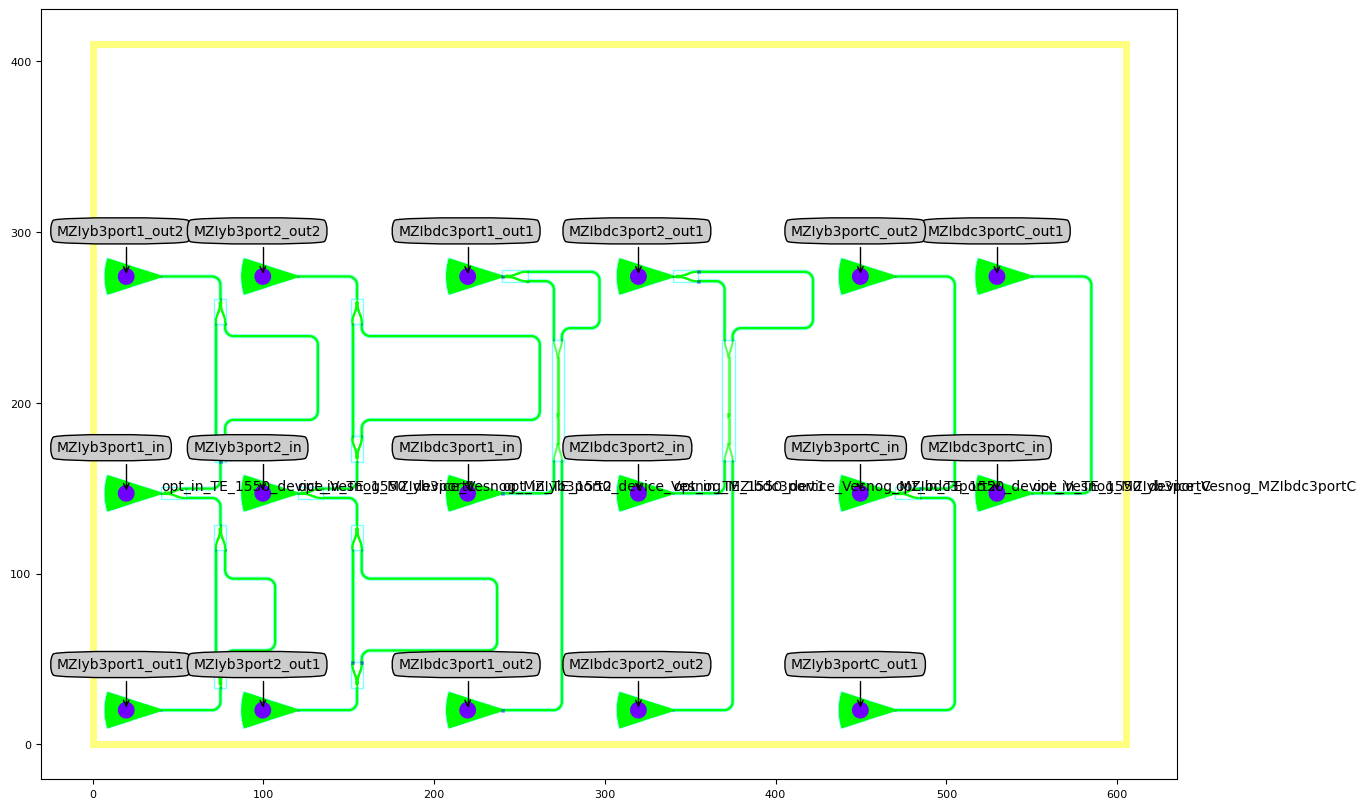

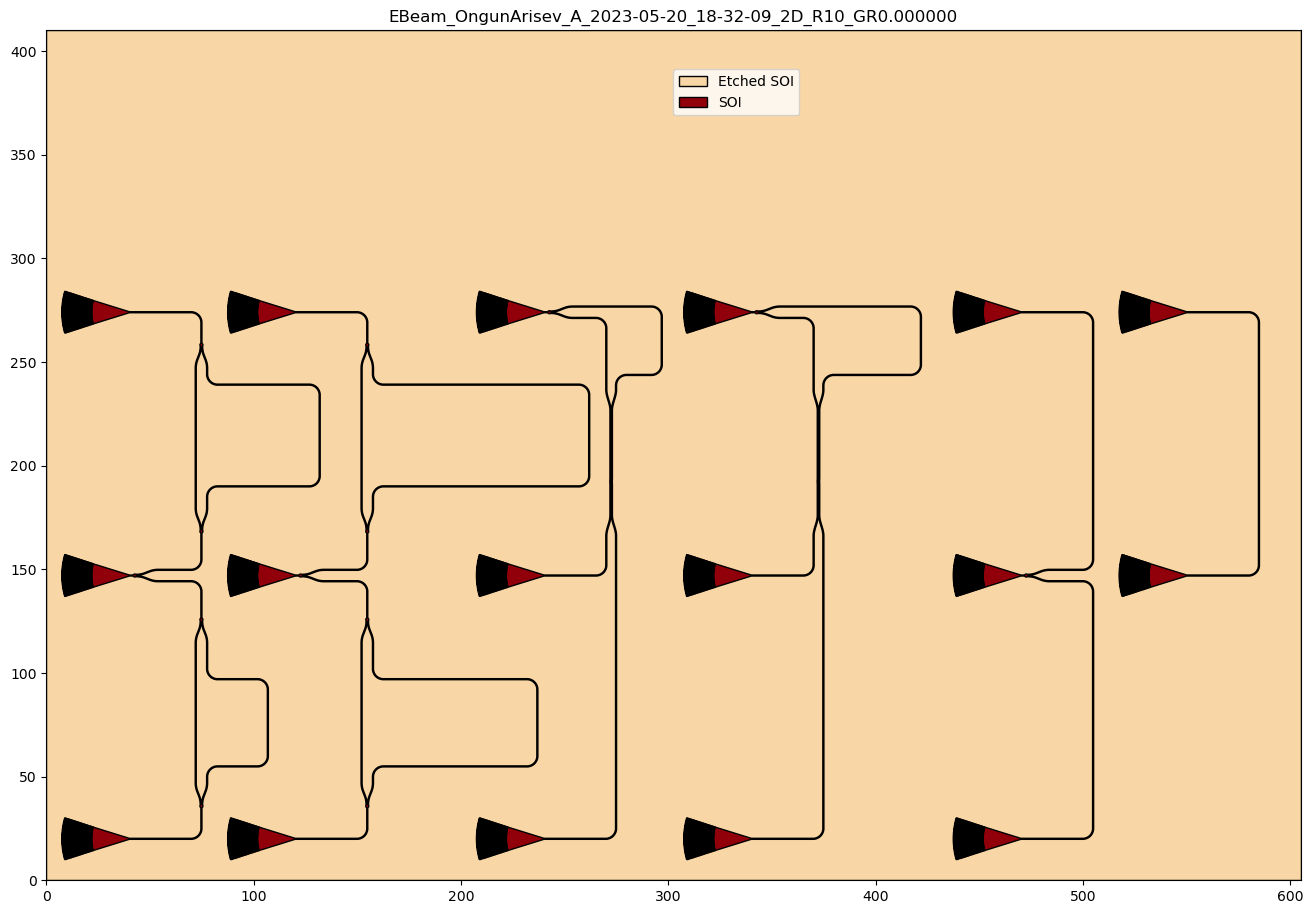

C:\Users\ongun\PycharmProjects\ipkiss_training\EBeam_Vesnog.gds

In [14]:
# Layout
filename = "EBeam_Vesnog.gds"
cell_lv = top_cell.Layout()
cell_lv.append(text_elems)
cell_lv.visualize(annotate=True)
cell_lv.visualize_2d()
cell_lv.write_gdsii(filename, layer_map=output_layer_map)

In [15]:
# Circuit model
cell_cm = top_cell.CircuitModel()
wavelengths = np.linspace(1.50, 1.58, 4001)
S_total = cell_cm.get_smatrix(wavelengths=wavelengths)

C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\simulation\engines\caphe_circuit_sim\caphenodegenerator.py:376: UserWarning: The following child nodes are not connected and will be removed:
floorplan
  warn(msg)


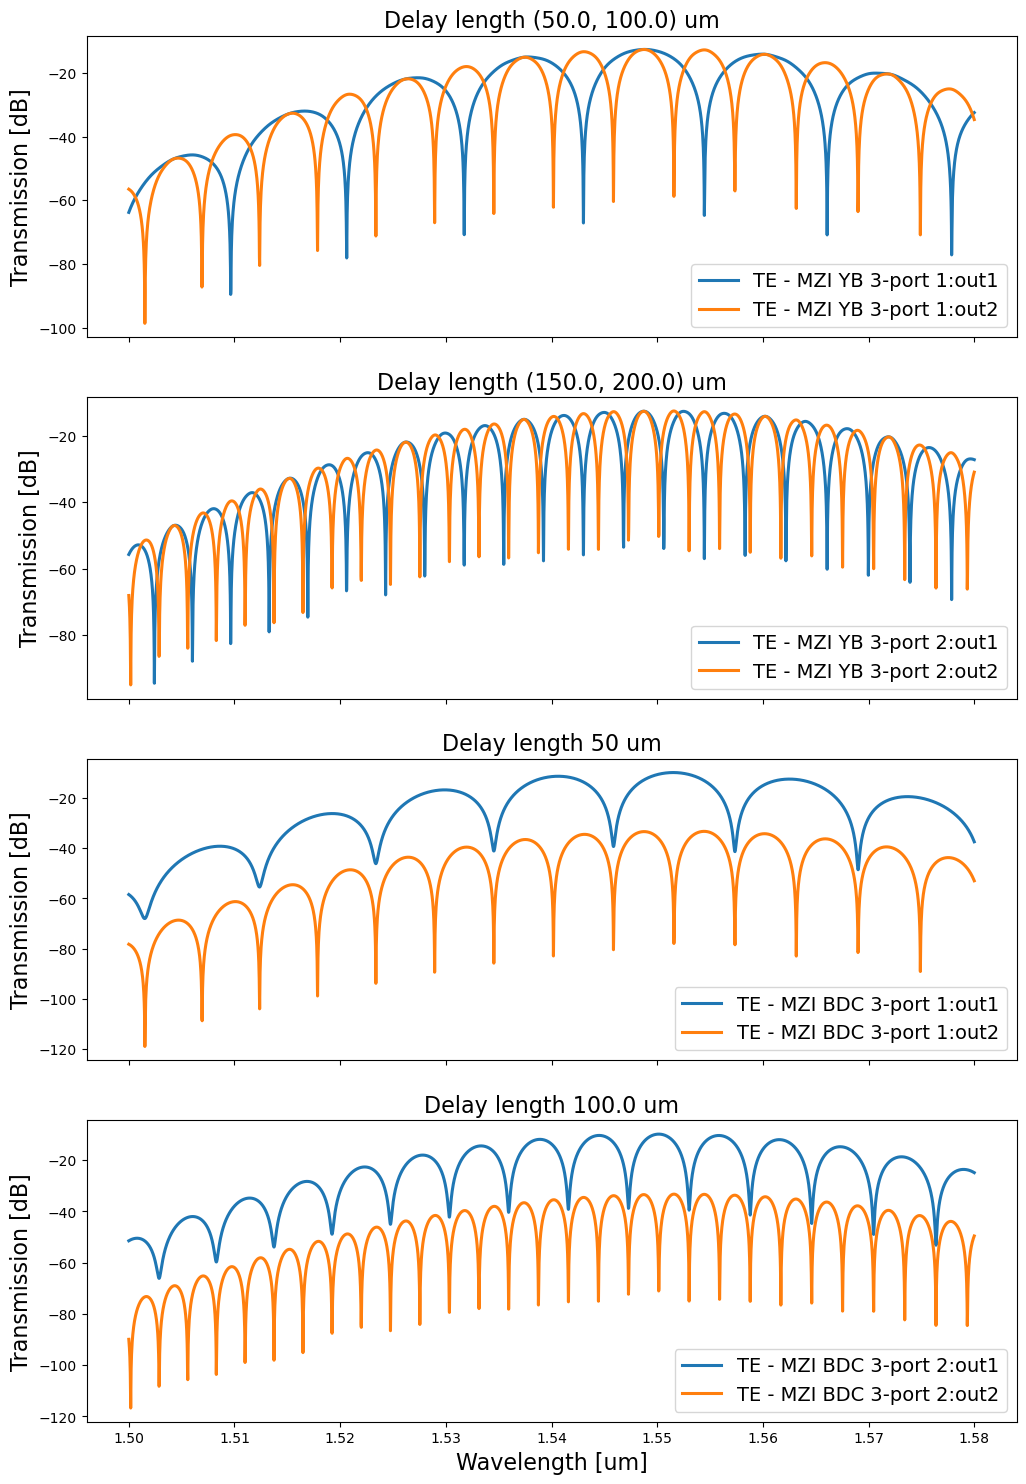

Done


In [16]:
# Plotting
fig, axs = plt.subplots(len(delay_lengths_tuples) + len(delay_lengths), sharex="all", figsize=(12, 18))

# Dictionary for saving variables
m_dict = {}

for ind, delay_length in enumerate(delay_lengths_tuples, start=1):
    # After the colon the mode is selected (two modes) / for the particular examples S-matrix has 12x12x2 entries
    # not counting the ones due to wavelength
    tr_out1 = i3.signal_power_dB(S_total["MZIyb3port{}_out1:0".format(ind), "MZIyb3port{}_in:0".format(ind)])
    tr_out2 = i3.signal_power_dB(S_total["MZIyb3port{}_out2:0".format(ind), "MZIyb3port{}_in:0".format(ind)])

    # Indices of the axes will be zero based
    ax_idx = ind - 1
    axs[ax_idx].plot(wavelengths, tr_out1, "-", linewidth=2.2, label="TE - MZI YB 3-port {}:out1".format(ind))
    axs[ax_idx].plot(wavelengths, tr_out2, "-", linewidth=2.2, label="TE - MZI YB 3-port {}:out2".format(ind))

    axs[ax_idx].set_ylabel("Transmission [dB]", fontsize=16)
    axs[ax_idx].set_title("Delay length {} um".format(delay_length), fontsize=16)
    axs[ax_idx].legend(fontsize=14, loc=4)
    m_dict[f"MZI_YB_3port_{delay_length}"] = {"out1": tr_out1, "out2": tr_out2}

for ind2, delay_length in enumerate(delay_lengths, start=1):
    tr_out1 = i3.signal_power_dB(S_total["MZIbdc3port{}_out1:0".format(ind2), "MZIbdc3port{}_in:0".format(ind2)])
    tr_out2 = i3.signal_power_dB(S_total["MZIbdc3port{}_out2:0".format(ind2), "MZIbdc3port{}_in:0".format(ind2)])

    # Indices of the axes will be zero based
    ax_idx2 = ind2 + ax_idx
    axs[ax_idx2].plot(wavelengths, tr_out1, "-", linewidth=2.2, label="TE - MZI BDC 3-port {}:out1".format(ind2))
    axs[ax_idx2].plot(wavelengths, tr_out2, "-", linewidth=2.2, label="TE - MZI BDC 3-port {}:out2".format(ind2))

    axs[ax_idx2].set_ylabel("Transmission [dB]", fontsize=16)
    axs[ax_idx2].set_title("Delay length {} um".format(delay_length), fontsize=16)
    axs[ax_idx2].legend(fontsize=14, loc=4)
    m_dict[f"MZI_BDC_3port_{delay_length}"] = {"out1": tr_out1, "out2": tr_out2}


savemat(f'./data/MZI_circuitA.mat', m_dict)
with open(f'./data/MZI_circuitA.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(m_dict, f)
axs[-1].set_xlabel("Wavelength [um]", fontsize=16)
plt.show()

print("Done")